# Penalized Linear Regressions: A Simulation Experiment

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import warnings
warnings.simplefilter('ignore')
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV, ElasticNetCV, LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.base import BaseEstimator
random.seed(1)

## Data Generating Process

We define a simple data generating process that allows for sparse, dense, and sparse+dense coefficients

In [5]:
def gen_data(n, p, *, regime="sparse"):
    # constants chosen to get R^2 of approximately .80
    if regime == "sparse":
        beta = ((1 / np.arange(1, p + 1)) ** 2) * 7
    elif regime == "dense":
        beta = ((np.random.normal(0, 1, p)) * 0.35)
    elif regime == "sparsedense":
        # taking out either results in an R^2 of approximately .69
        beta = (((1 / np.arange(1, p + 1)) ** 2) * 5) + ((np.random.normal(0, 1, p)) * 0.25)

    def true_fn(x):
        return x @ beta #矩阵乘法，X的维度是 (n,p) , beta的维度是 (p,1)

    X = np.random.uniform(-.5, .5, size=(n, p))
    gX = true_fn(X)
    y = gX + np.random.normal(0, 1, size=n)
    Xtest = np.random.uniform(-.5, .5, size=(n, p))
    gXtest = true_fn(Xtest)
    ytest = gXtest + np.random.normal(0, 1, size=n)
    Xpop = np.random.uniform(-.5, .5, size=(100000, p))  # almost population limit
    gXpop = true_fn(Xpop)
    ypop = gXpop + np.random.normal(0, 1, size=100000)  # almost population limit
    return X, y, gX, Xtest, ytest, gXtest, Xpop, ypop, gXpop, beta

## Data Generating Process: Approximately Sparse

In [7]:
n = 100
p = 400
X, y, gX, Xtest, ytest, gXtest, Xpop, ypop, gXpop, betas = gen_data(n, p, regime="sparse")

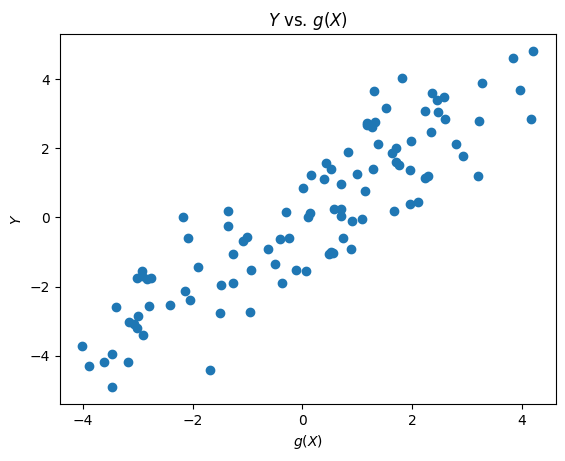

In [16]:
plt.figure()
plt.title(r"$Y$ vs. $g(X)$")
plt.scatter(gX, y)  # gX是 BLP能够得到的结果，非随机部分
plt.xlabel(r"$g(X)$")
plt.ylabel(r"$Y$")
plt.show() #基本是45度线

In [ ]:
print(f"theoretical R^2:, {1 - np.var(ypop - gXpop) / np.var(ypop)}")
print(f"theoretical R^2:, {np.var(gXpop) / np.var(ypop)}")

In [ ]:
plt.figure()
plt.scatter(range(len(betas)), abs(betas), s=5, color='b')
plt.xlabel(r'$\beta$')
plt.ylabel('Magnitude (log scale)')
plt.title(r'$\beta$ Magnitude')
plt.yscale('log')
plt.show()

## Lasso, Ridge, ElasticNet

We use sklearn's penalized estimators, which choose the penalty parameter via cross-validation (by default 5-fold cross-validation). These methods search over an adaptively chosen grid of hyperparameters. `ElasticNet` allows for a convex combination of `l1` and `l2` penalty and the ratio with `l1_ratio` corresponding to the proportion of the `l1` penalty.

In [ ]:
# Regressions
lcv = LassoCV().fit(X, y)
ridge = RidgeCV().fit(X, y)
enet = ElasticNetCV(l1_ratio=0.5).fit(X, y)

We calculate the R-squared on the small test set that we have

In [ ]:
r2_lcv = r2_score(ytest, lcv.predict(Xtest))
r2_ridge = r2_score(ytest, ridge.predict(Xtest))
r2_enet = r2_score(ytest, enet.predict(Xtest))
r2_lcv, r2_ridge, r2_enet

We also calculate what the R-squared would be in the population limit (in our case for practical purposes when we have a very very large test sample)

In [ ]:
r2_lcv = r2_score(ypop, lcv.predict(Xpop))
r2_ridge = r2_score(ypop, ridge.predict(Xpop))
r2_enet = r2_score(ypop, enet.predict(Xpop))
r2_lcv, r2_ridge, r2_enet

We can also try this with fitting OLS after Lasso selects variables, but note, this is the wrong post-lasso OLS with cross-validation!

In [ ]:
class PostLassoOLS:

    def fit(self, X, y):
        lasso = LassoCV().fit(X, y)
        self.feats_ = np.abs(lasso.coef_) > 1e-6
        self.lr_ = LinearRegression().fit(X[:, self.feats_], y)
        return self

    def predict(self, X):
        return self.lr_.predict(X[:, self.feats_])

    @property
    def coef_(self):
        return self.lr_.coef_

In [ ]:
plols = PostLassoOLS().fit(X, y)
r2_score(ypop, plols.predict(Xpop))

## Plug-in Hyperparameter Lasso and Post-Lasso OLS

Here we compute the lasso and ols post lasso using plug-in choices for penalty levels.

\We use "plug-in" tuning with a theoretically valid choice of penalty $\lambda = 2 \cdot c \hat{\sigma} \sqrt{n} \Phi^{-1}(1-\alpha/2p)$, where $c>1$ and $1-\alpha$ is a confidence level, and $\Phi^{-1}$ denotes the quantile function. Under homoskedasticity, this choice ensures that the Lasso predictor is well behaved, delivering good predictive performance under approximate sparsity. In practice, this formula will work well even in the absence of homoskedasticity, especially when the random variables $\epsilon$ and $X$ in the regression equation decay quickly at the tails.

In practice, many people choose to use cross-validation, which is perfectly fine for predictive tasks. However, when conducting inference, to make our analysis valid we will require cross-fitting in addition to cross-validation. As we have not yet discussed cross-fitting, we rely on this theoretically-driven penalty in order to allow for accurate inference in the upcoming notebooks.

We pull an analogue of R's rlasso. Rlasso functionality: it is searching the right set of regressors. This function was made for the case of ***p*** regressors and ***n*** observations where ***p >>>> n***. It assumes that the error is i.i.d. The errors may be non-Gaussian or heteroscedastic.\
The post lasso function makes OLS with the selected ***T*** regressors.
To select those parameters, they use $\lambda$ as variable to penalize\
**Funny thing: the function rlasso was named like that because it is the "rigorous" Lasso.**\
We find a Python code that tries to replicate the main function of hdm r-package. It was made by [Max Huppertz](https://maxhuppertz.github.io/code/). His library is this [repository](https://github.com/maxhuppertz/hdmpy). If not using colab, download its repository and copy this folder to your site-packages folder. In my case it is located here ***C:\Python\Python38\Lib\site-packages*** . We need to install this package ***pip install multiprocess***.

In [ ]:
!git clone https://github.com/maxhuppertz/hdmpy.git
!pip install multiprocess

In [ ]:
# We wrap the package so that it has the familiar sklearn API
import hdmpy


class RLasso(BaseEstimator):

    def __init__(self, *, post=True):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    def predict(self, X):
        return X @ np.array(self.rlasso_.est['beta']).flatten() + np.array(self.rlasso_.est['intercept'])

In [ ]:
rlasso = RLasso(post=False).fit(X, y)
rlasso_post = RLasso(post=True).fit(X, y)

In [ ]:
r2_rlasso = r2_score(ytest, rlasso.predict(Xtest))
r2_rlasso_post = r2_score(ytest, rlasso_post.predict(Xtest))
r2_rlasso, r2_rlasso_post

In [ ]:
r2_rlasso = r2_score(ypop, rlasso.predict(Xpop))
r2_rlasso_post = r2_score(ypop, rlasso_post.predict(Xpop))
r2_rlasso, r2_rlasso_post

## LAVA: Dense + Sparse Coefficients

Now let's try the LAVA estimator

In [ ]:
# We construct an sklearn API estimator that implements the LAVA method


class Lava(BaseEstimator):

    def __init__(self, *, alpha1=1, alpha2=1, iterations=5):
        self.alpha1 = alpha1  # l1 penalty
        self.alpha2 = alpha2
        self.iterations = iterations

    def fit(self, X, y):
        ridge = Ridge(self.alpha2).fit(X, y)
        lasso = Lasso(self.alpha1).fit(X, y - ridge.predict(X))

        for _ in range(self.iterations - 1):
            ridge = ridge.fit(X, y - lasso.predict(X))
            lasso = lasso.fit(X, y - ridge.predict(X))

        self.lasso_ = lasso
        self.ridge_ = ridge
        return self

    def predict(self, X):
        return self.lasso_.predict(X) + self.ridge_.predict(X)

In [ ]:
lava = GridSearchCV(Lava(), {'alpha1': np.logspace(-4, 4, 20), 'alpha2': np.logspace(-4, 4, 20)},
                    scoring='r2', n_jobs=-1)
lava.fit(X, y)

In [ ]:
lava.best_estimator_

In [ ]:
r2_lava = r2_score(ytest, lava.predict(Xtest))
r2_lava

In [ ]:
r2_lava = r2_score(ypop, lava.predict(Xpop))
r2_lava

## Summarizing Results

In [ ]:
df = pd.DataFrame({'LassoCV': [r2_lcv],
                   'RidgeCV': [r2_ridge],
                   'ElasticNetCV': [r2_enet],
                   'RLasso': [r2_rlasso],
                   'RLassoOLS': [r2_rlasso_post],
                   'Lava': [r2_lava]}).T
df.columns = ['Population R-squared']
df

In [ ]:
plt.figure()
plt.title("Different Models for Approximately Sparse Regime")
# 45 degree line
plt.plot([np.min(gXtest), np.max(gXtest)], [np.min(gXtest), np.max(gXtest)], color='black', linestyle='--')

# different models
plt.scatter(gXtest, ridge.predict(Xtest), marker='^', c='brown', s=5, label='Ridge')
plt.scatter(gXtest, enet.predict(Xtest), marker='v', c='yellow', s=5, label='ENet')
plt.scatter(gXtest, rlasso.predict(Xtest), marker='D', c='red', s=5, label='RLasso')
plt.scatter(gXtest, rlasso_post.predict(Xtest), marker='o', c='green', s=5, label='RLasso Post')
plt.scatter(gXtest, lcv.predict(Xtest), marker='<', c='blue', s=5, label='LassoCV')
plt.scatter(gXtest, lava.predict(Xtest), marker='>', c='magenta', s=5, label='Lava')
plt.legend(loc='lower right')

plt.show()

## Data Generating Process: Dense Coefficients

In [ ]:
n = 100
p = 400
X, y, gX, Xtest, ytest, gXtest, Xpop, ypop, gXpop, betas = gen_data(n, p, regime="dense")

In [ ]:
plt.figure()
plt.title(r"$Y$ vs. $g(X)$")
plt.scatter(gX, y)
plt.xlabel(r"$g(X)$")
plt.ylabel(r"$Y$")
plt.show()

In [ ]:
print(f"theoretical R^2:, {1 - np.var(ypop - gXpop) / np.var(ypop)}")
print(f"theoretical R^2:, {np.var(gXpop) / np.var(ypop)}")

In [ ]:
plt.figure()
plt.scatter(range(len(betas)), abs(betas), s=5, color='b')
plt.xlabel(r'$\beta$')
plt.ylabel('Magnitude (log scale)')
plt.title(r'$\beta$ Magnitude')
plt.yscale('log')
plt.show()

In [ ]:
# Regressions
lcv = LassoCV().fit(X, y)
ridge = RidgeCV(alphas=(1, 10, 25, 50, 100)).fit(X, y)
enet = ElasticNetCV(l1_ratio=0.5).fit(X, y)
rlasso = RLasso(post=False).fit(X, y)
rlasso_post = RLasso(post=True).fit(X, y)
lava = GridSearchCV(Lava(), {'alpha1': np.logspace(-4, 4, 20), 'alpha2': np.logspace(-4, 4, 20)},
                    scoring='r2', n_jobs=-1).fit(X, y)

In [ ]:
r2_lcv = r2_score(ypop, lcv.predict(Xpop))
r2_ridge = r2_score(ypop, ridge.predict(Xpop))
r2_enet = r2_score(ypop, enet.predict(Xpop))
r2_rlasso = r2_score(ypop, rlasso.predict(Xpop))
r2_rlasso_post = r2_score(ypop, rlasso_post.predict(Xpop))
r2_lava = r2_score(ypop, lava.predict(Xpop))

In [ ]:
df = pd.DataFrame({'LassoCV': [r2_lcv],
                   'RidgeCV': [r2_ridge],
                   'ElasticNetCV': [r2_enet],
                   'RLasso': [r2_rlasso],
                   'RLassoOLS': [r2_rlasso_post],
                   'Lava': [r2_lava]}).T
df.columns = ['Population R-squared']
df

In [ ]:
plt.figure()
plt.title("Different Models for Dense Regime")
# 45 degree line
plt.plot([np.min(gXtest), np.max(gXtest)], [np.min(gXtest), np.max(gXtest)], color='black', linestyle='--')

# different models
plt.scatter(gXtest, ridge.predict(Xtest), marker='^', c='brown', s=5, label='Ridge')
plt.scatter(gXtest, enet.predict(Xtest), marker='v', c='yellow', s=5, label='ENet')
plt.scatter(gXtest, rlasso.predict(Xtest), marker='D', c='red', s=5, label='RLasso')
plt.scatter(gXtest, rlasso_post.predict(Xtest), marker='o', c='green', s=5, label='RLasso Post')
plt.scatter(gXtest, lcv.predict(Xtest), marker='<', c='blue', s=5, label='LassoCV')
plt.scatter(gXtest, lava.predict(Xtest), marker='>', c='magenta', s=5, label='Lava')
plt.legend(loc='lower right')

plt.show()

## Data Generating Process: Approximately Sparse + Small Dense Part

In [ ]:
n = 100
p = 400
X, y, gX, Xtest, ytest, gXtest, Xpop, ypop, gXpop, betas = gen_data(n, p, regime="sparsedense")

In [ ]:
plt.figure()
plt.title(r"$Y$ vs. $g(X)$")
plt.scatter(gX, y)
plt.xlabel(r"$g(X)$")
plt.ylabel(r"$Y$")
plt.show()

In [ ]:
print(f"theoretical R^2:, {1 - np.var(ypop - gXpop) / np.var(ypop)}")
print(f"theoretical R^2:, {np.var(gXpop) / np.var(ypop)}")

In [ ]:
plt.figure()
plt.scatter(range(len(betas)), abs(betas), s=5, color='b')
plt.xlabel(r'$\beta$')
plt.ylabel('Magnitude (log scale)')
plt.title(r'$\beta$ Magnitude')
plt.yscale('log')
plt.show()

In [ ]:
# Regressions
lcv = LassoCV().fit(X, y)
ridge = RidgeCV().fit(X, y)
enet = ElasticNetCV(l1_ratio=0.5).fit(X, y)
rlasso = RLasso(post=False).fit(X, y)
rlasso_post = RLasso(post=True).fit(X, y)
lava = GridSearchCV(Lava(), {'alpha1': np.logspace(-4, 4, 20), 'alpha2': np.logspace(-4, 4, 20)},
                    scoring='r2', n_jobs=-1).fit(X, y)

In [ ]:
r2_lcv = r2_score(ypop, lcv.predict(Xpop))
r2_ridge = r2_score(ypop, ridge.predict(Xpop))
r2_enet = r2_score(ypop, enet.predict(Xpop))
r2_rlasso = r2_score(ypop, rlasso.predict(Xpop))
r2_rlasso_post = r2_score(ypop, rlasso_post.predict(Xpop))
r2_lava = r2_score(ypop, lava.predict(Xpop))

In [ ]:
df = pd.DataFrame({'LassoCV': [r2_lcv],
                   'RidgeCV': [r2_ridge],
                   'ElasticNetCV': [r2_enet],
                   'RLasso': [r2_rlasso],
                   'RLassoOLS': [r2_rlasso_post],
                   'Lava': [r2_lava]}).T
df.columns = ['Population R-squared']
df

In [ ]:
plt.figure()
plt.title("Different Models for Approximately Sparse + Dense Regime")
# 45 degree line
plt.plot([np.min(gXtest), np.max(gXtest)], [np.min(gXtest), np.max(gXtest)], color='black', linestyle='--')

# different models
plt.scatter(gXtest, ridge.predict(Xtest), marker='^', c='brown', s=5, label='Ridge')
plt.scatter(gXtest, enet.predict(Xtest), marker='v', c='yellow', s=5, label='ENet')
plt.scatter(gXtest, rlasso.predict(Xtest), marker='D', c='red', s=5, label='RLasso')
plt.scatter(gXtest, rlasso_post.predict(Xtest), marker='o', c='green', s=5, label='RLasso Post')
plt.scatter(gXtest, lcv.predict(Xtest), marker='<', c='blue', s=5, label='LassoCV')
plt.scatter(gXtest, lava.predict(Xtest), marker='>', c='magenta', s=5, label='Lava')
plt.legend(loc='lower right')

plt.show()